In [1]:
import time

import astropy.units as u

import gala.dynamics as gd
import gala.potential as gp
from gala.dynamics import mockstream as ms

import jax
import jax.numpy as jnp
from jax import config

import matplotlib.pyplot as plt

import numpy as np

import galdynamix.potential as gpx
import galdynamix.dynamics as gdx
from galdynamix.units import UnitSystem

config.update("jax_enable_x64", True)

## Potentials

In [2]:
usys = UnitSystem(u.kpc, u.Myr, u.Msun, u.radian)

In [3]:
## Define a MW Potential Model
params_global = {
    "m_disk": 5.0e10 * u.Msun,
    "a_disk": 3.0,
    "b_disk": 0.25,
    "m_NFW": 1.0e12,
    "r_s_NFW": 15.0,
}
pot_disk = gpx.MiyamotoNagaiPotential(
    m=params_global["m_disk"],
    a=params_global["a_disk"],
    b=params_global["b_disk"],
    units=usys,
)
pot_NFW = gpx.NFWPotential(
    m=params_global["m_NFW"] * u.Msun,
    r_s=params_global["r_s_NFW"],
    softening_length=(0.001 * u.kpc).to(u.Mpc),
    units=usys,
)

## Combine potentials
# potential_list = [pot_disk, pot_NFW]
potential_list = {"disk": pot_disk, "NFW": pot_NFW}
pot = gpx.CompositePotential(**potential_list, units=usys)

In [4]:
## Gala equivalent
pot_gala_disk = gp.MiyamotoNagaiPotential(
    m=params_global["m_disk"],
    a=params_global["a_disk"],
    b=params_global["b_disk"],
    units=usys,  # note that galdyanmix's UnitSystem is compatible with gala's
)

pot_gala_NFW = gp.NFWPotential(
    m=params_global["m_NFW"],
    r_s=params_global["r_s_NFW"],
    units=usys,
)

pot_gala = pot_gala_disk + pot_gala_NFW
H = gp.Hamiltonian(pot_gala)

## Integrating Orbits

In [5]:
# Galdynamix doesn't yet have full unit support

t0 = 0.0
dt = 0.5
n_steps = 8_000  # 8_000#8_000
w0 = jnp.array(
    [
        30.0,
        10.0,
        20,
        (10 * u.km / u.s).decompose(usys).value,
        (-150 * u.km / u.s).decompose(usys).value,
        (-20 * u.km / u.s).decompose(usys).value,
    ]
)
ts = jnp.arange(t0, t0 + dt * n_steps + dt / 10.0, dt)

In [6]:
o_jax = pot.integrate_orbit(w0, t0, jnp.max(ts), ts)
ws_jax = o_jax.to_w()

And with Gala

In [7]:
w0_gala = gd.PhaseSpacePosition(pos=w0[:3].T * u.kpc, vel=w0[3:].T * u.kpc / u.Myr)

o_gala = H.integrate_orbit(w0=w0_gala, t=np.array(ts))

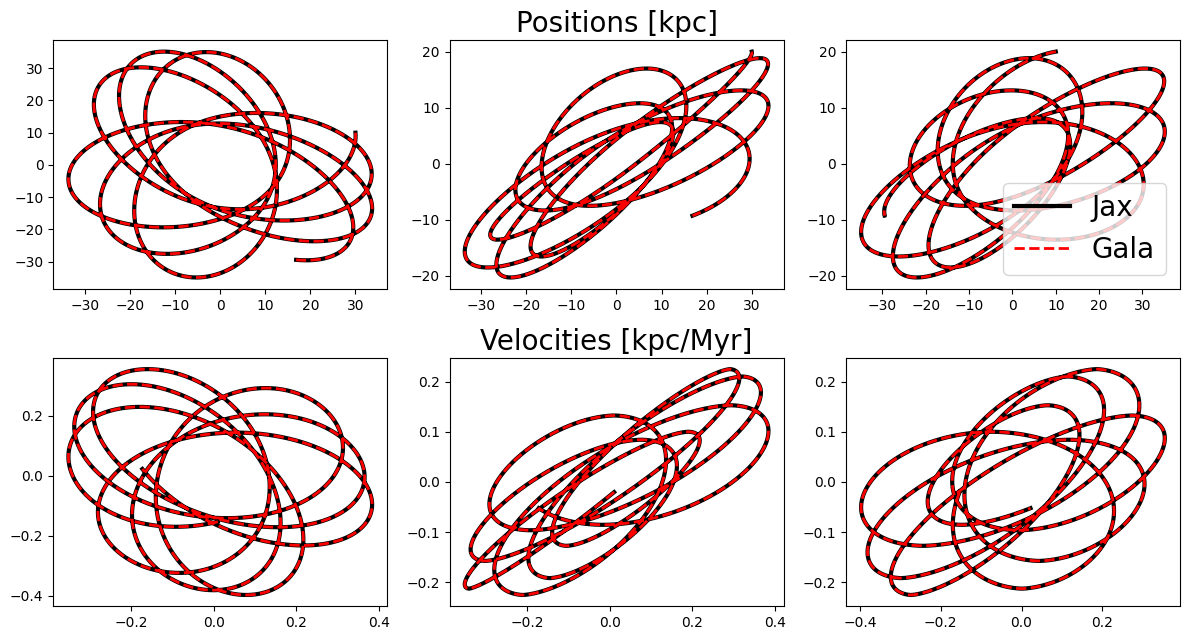

In [8]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(12, 6.5)
lw = 3
ax[0, 0].plot(ws_jax[:, 0], ws_jax[:, 1], color="k", lw=lw, rasterized=True)
ax[0, 1].plot(ws_jax[:, 0], ws_jax[:, 2], color="k", lw=lw, rasterized=True)
ax[0, 2].plot(
    ws_jax[:, 1], ws_jax[:, 2], color="k", lw=lw, rasterized=True, label="Jax"
)

ax[1, 0].plot(ws_jax[:, 3], ws_jax[:, 4], color="k", lw=lw, rasterized=True)
ax[1, 1].plot(ws_jax[:, 3], ws_jax[:, 5], color="k", lw=lw, rasterized=True)
ax[1, 2].plot(ws_jax[:, 4], ws_jax[:, 5], color="k", lw=lw, rasterized=True)


ax[0, 0].plot(o_gala.x, o_gala.y, color="r", ls="--", lw=2, rasterized=True)
ax[0, 1].plot(o_gala.x, o_gala.z, color="r", ls="--", lw=2, rasterized=True)
ax[0, 2].plot(
    o_gala.y, o_gala.z, color="r", ls="--", lw=2, rasterized=True, label="Gala"
)

ax[1, 0].plot(o_gala.v_x, o_gala.v_y, color="r", ls="--", lw=2, rasterized=True)
ax[1, 1].plot(o_gala.v_x, o_gala.v_z, color="r", ls="--", lw=2, rasterized=True)
ax[1, 2].plot(o_gala.v_y, o_gala.v_z, color="r", ls="--", lw=2, rasterized=True)

ax[0, 1].set_title("Positions [kpc]", fontsize=20)
ax[1, 1].set_title("Velocities [kpc/Myr]", fontsize=20)

ax[0, 2].legend(fontsize=20)
plt.tight_layout()

## Mock Streams

In [9]:
M_sat = 1.0e4  # progenitor mass
seed_num = 12
dfx = gdx.mockstream.FardalStreamDF()
mock = gdx.mockstream.MockStreamGenerator(dfx, pot)
(lead_arm, trail_arm), prog_ws = mock.run(ts, w0, M_sat, seed_num=seed_num)  # compile

start = time.time()
(lead_arm, trail_arm), prog_ws = mock.run(ts, w0, M_sat, seed_num=seed_num)
end = time.time()
print("time:", end - start)

jax_stream_model = np.vstack([lead_arm, trail_arm])

1.31404709815979


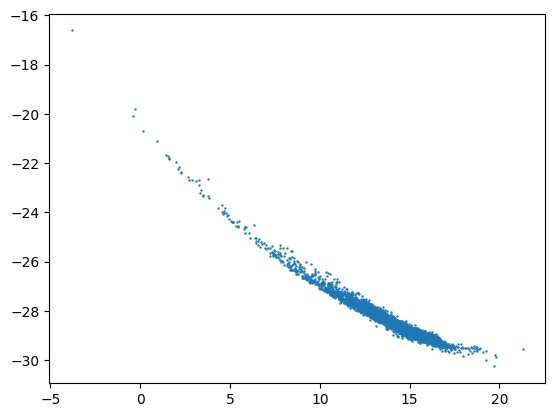

In [10]:
plt.scatter(lead_arm[:, 0], lead_arm[:, 1], s=0.5, rasterized=True)

Now in gala

In [12]:
df = ms.FardalStreamDF()
prog_mass = M_sat * u.Msun
gen = ms.MockStreamGenerator(df, H)
start = time.time()

stream, prog = gen.run(
    w0_gala, prog_mass, t=np.array(ts) * u.Myr, release_every=1, n_particles=1
)
end = time.time()
print(end - start)

7.697719097137451


Comparison plot

/var/folders/lt/4kxx3wjs4y17_nrgc1psr2fr0000gn/T/ipykernel_29878/3111956643.py:53: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[0]._sizes = [30]
/var/folders/lt/4kxx3wjs4y17_nrgc1psr2fr0000gn/T/ipykernel_29878/3111956643.py:54: MatplotlibDeprecationWarning: The legendHandles attribute was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use legend_handles instead.
  lgnd.legendHandles[1]._sizes = [30]


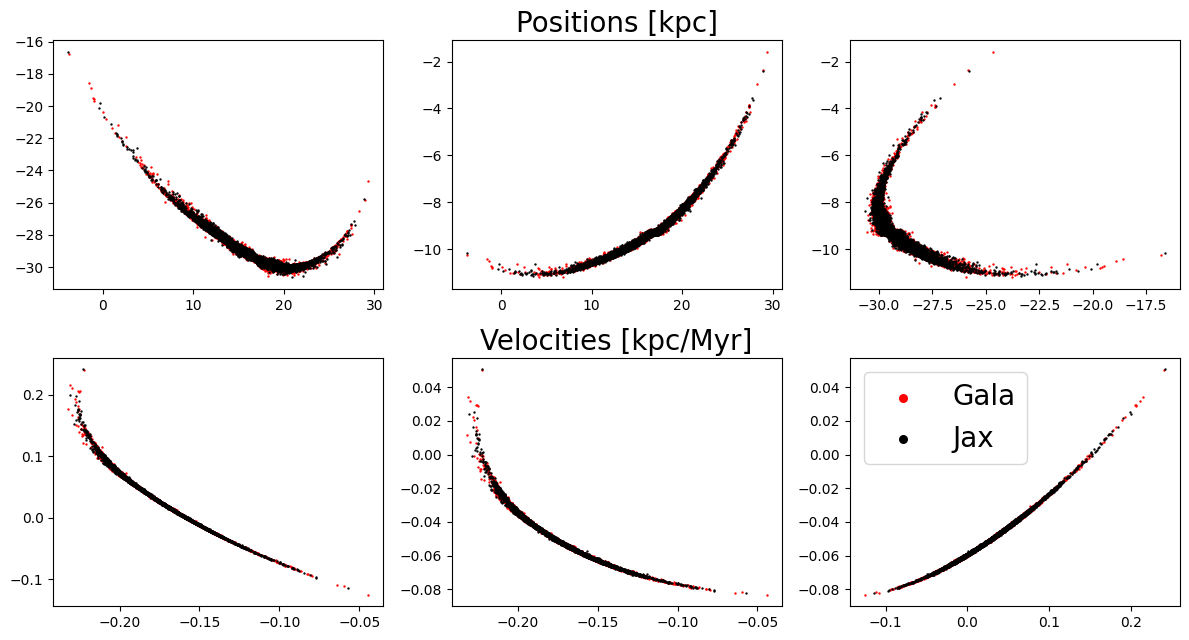

In [13]:
fig, ax = plt.subplots(2, 3)
fig.set_size_inches(12, 6.5)
s = 0.5
# ax[0,0].scatter(jax_stream_model[:,0],jax_stream_model[:,1],s=s,rasterized=True,color='k')
ax[0, 0].scatter(stream.x, stream.y, s=0.5, rasterized=True, color="r")
ax[0, 0].scatter(
    jax_stream_model[:, 0], jax_stream_model[:, 1], s=s, rasterized=True, color="k"
)

ax[0, 1].scatter(stream.x, stream.z, s=0.5, rasterized=True, color="r")
ax[0, 1].scatter(
    jax_stream_model[:, 0], jax_stream_model[:, 2], s=s, rasterized=True, color="k"
)

ax[0, 2].scatter(stream.y, stream.z, s=0.5, rasterized=True, color="r", label="Gala")
ax[0, 2].scatter(
    jax_stream_model[:, 1],
    jax_stream_model[:, 2],
    s=s,
    rasterized=True,
    color="k",
    label="Jax",
)


ax[1, 0].scatter(stream.v_x, stream.v_y, s=0.5, rasterized=True, color="r")
ax[1, 0].scatter(
    jax_stream_model[:, 3], jax_stream_model[:, 4], s=s, rasterized=True, color="k"
)

ax[1, 1].scatter(stream.v_x, stream.v_z, s=0.5, rasterized=True, color="r")
ax[1, 1].scatter(
    jax_stream_model[:, 3], jax_stream_model[:, 5], s=s, rasterized=True, color="k"
)

ax[1, 2].scatter(
    stream.v_y, stream.v_z, s=0.5, rasterized=True, color="r", label="Gala"
)
ax[1, 2].scatter(
    jax_stream_model[:, 4],
    jax_stream_model[:, 5],
    s=s,
    rasterized=True,
    color="k",
    label="Jax",
)


ax[0, 1].set_title("Positions [kpc]", fontsize=20)
ax[1, 1].set_title("Velocities [kpc/Myr]", fontsize=20)

lgnd = ax[1, 2].legend(fontsize=20, frameon=True)
lgnd.legendHandles[0]._sizes = [30]
lgnd.legendHandles[1]._sizes = [30]
plt.tight_layout()
##plt.savefig('DiskSphericalNFW_jax_Gala_Stream.pdf',bbox_inches='tight')

## Demonstrating Gradients

In [14]:
ts = jnp.linspace(t0, 4000.0, n_steps)

In [15]:
mock = gdx.mockstream.MockStreamGenerator(dfx, pot)
lead_arm_obs, trail_arm_obs = mock.run(ts, w0, M_sat, seed_num=seed_num)

In [16]:
pot_disk = gpx.MiyamotoNagaiPotential(
    m=params_global["m_disk"],
    a=params_global["a_disk"],
    b=params_global["b_disk"],
    units=usys,
)
pot_NFW = gpx.NFWPotential(
    m=params_global["m_NFW"],
    r_s=params_global["r_s_NFW"],
    units=usys,
)

# Combine potentials
potential_list = {"disk": pot_disk, "NFW": pot_NFW}
pot_with_params = gpx.CompositePotential(potential_list, units=usys)
mock = gdx.mockstream.MockStreamGenerator(dfx, pot_with_params)

lead_arm_obs__, trail_arm_obs__ = mock.run(ts, w0, M_sat, seed_num=seed_num)

In [17]:
@jax.jit
def gen_observed_stream(params, ts, w0, M_sat):
    pot_disk = gpx.MiyamotoNagaiPotential(
        m=params["m_disk"], a=params["a_disk"], b=params["b_disk"], units=usys
    )
    pot_NFW = gpx.NFWPotential(m=params["m_NFW"], r_s=params["r_s_NFW"], units=usys)
    ## Combine potentials
    # potential_list = [pot_disk, pot_NFW]
    potential_list = {"disk": pot_disk, "NFW": pot_NFW}
    pot = gpx.CompositePotential(potential_list, units=usys)

    ## Generate a stream. This will be the "observed" stream, i.e., the DATA
    mock = gdx.mockstream.MockStreamGenerator(dfx, pot)
    (lead_arm, trail_arm), prog_ws = mock.run(ts, w0, M_sat, seed_num=seed_num)

    return lead_arm, trail_arm  # jnp.sum(lead_arm_obs**2 + trail_arm_obs**2)


@jax.jit
def compare_streams(params, ts, w0, M_sat):
    ## first generate data stream (no grad tracking)
    lead_arm, trail_arm = gen_observed_stream(params, ts, w0, M_sat)
    lead_arm_obs, trail_arm_obs = jax.lax.stop_gradient(
        lead_arm
    ), jax.lax.stop_gradient(trail_arm)
    return -jnp.sum((lead_arm - lead_arm_obs) ** 2 + (trail_arm - trail_arm_obs) ** 2)


func_params = lambda params: compare_streams(params, ts, w0, M_sat)
out_test = func_params(params_global)

In [18]:
@jax.jit
def deriv_func(params, ts, w0, M_sat):
    return jax.jacfwd(compare_streams, argnums=0)(params, ts, w0, M_sat)

In [19]:
first_deriv = deriv_func(params_global, ts, w0, M_sat)

In [20]:
first_deriv = deriv_func(params_global, ts, w0, M_sat)

In [21]:
first_deriv

{'a_disk': Array(-0., dtype=float64),
 'b_disk': Array(-0., dtype=float64),
 'm_NFW': Array(-0., dtype=float64),
 'm_disk': Array(-0., dtype=float64),
 'r_s_NFW': Array(-0., dtype=float64)}

In [22]:
second_deriv = jax.jacfwd(jax.jacfwd(compare_streams, argnums=0))(
    params_global, ts, w0, M_sat
)

In [23]:
second_deriv

{'a_disk': {'a_disk': Array(-968720.39540316, dtype=float64),
  'b_disk': Array(-63935.60979567, dtype=float64),
  'm_NFW': Array(5.05292811e-05, dtype=float64),
  'm_disk': Array(0.00018556, dtype=float64),
  'r_s_NFW': Array(-4252147.90709024, dtype=float64)},
 'b_disk': {'a_disk': Array(-63935.60979567, dtype=float64),
  'b_disk': Array(-9207.86945484, dtype=float64),
  'm_NFW': Array(5.20889691e-06, dtype=float64),
  'm_disk': Array(2.31091037e-05, dtype=float64),
  'r_s_NFW': Array(-445661.14634608, dtype=float64)},
 'm_NFW': {'a_disk': Array(5.05292811e-05, dtype=float64),
  'b_disk': Array(5.20889691e-06, dtype=float64),
  'm_NFW': Array(-4.86795236e-15, dtype=float64),
  'm_disk': Array(-1.63141696e-14, dtype=float64),
  'r_s_NFW': Array(0.00038019, dtype=float64)},
 'm_disk': {'a_disk': Array(0.00018556, dtype=float64),
  'b_disk': Array(2.31091037e-05, dtype=float64),
  'm_NFW': Array(-1.63141696e-14, dtype=float64),
  'm_disk': Array(-6.34713665e-14, dtype=float64),
  'r_s_N

# Benchmark

In [24]:
## Benchmark
n_release = [2000, 4000, 8000, 16000, 16000 * 2]
t_jax = []
for i in range(len(n_release)):
    ts = jnp.linspace(t0, 4000.0, n_release[i])
    start = time.time()
    (lead_arm, trail_arm), prog_ws = mock.run(ts, w0, M_sat, seed_num=seed_num)
    end = time.time()
    t_jax.append(end - start)
    print(end - start)

1.825002908706665
2.1949968338012695
1.3115370273590088
4.244686841964722
7.000908136367798


In [25]:
## now in gala
from gala.dynamics import mockstream as ms

df = ms.FardalStreamDF()
prog_mass = M_sat * u.Msun
gen = ms.MockStreamGenerator(df, H)
# start = time.time()
t_gala = []
for i in range(len(n_release)):
    ts = np.linspace(t0, 4000.0, n_release[i])
    start = time.time()
    stream, prog = gen.run(
        w0_gala, prog_mass, t=ts * u.Myr, release_every=1, n_particles=1
    )
    end = time.time()
    t_gala.append(end - start)
    print(end - start)

iteration 0
1.9202439785003662
4000
iteration 1
3.939486026763916
8000
iteration 2
7.696799039840698
16000
iteration 3
15.6858069896698
32000
iteration 4
31.67649507522583
64000


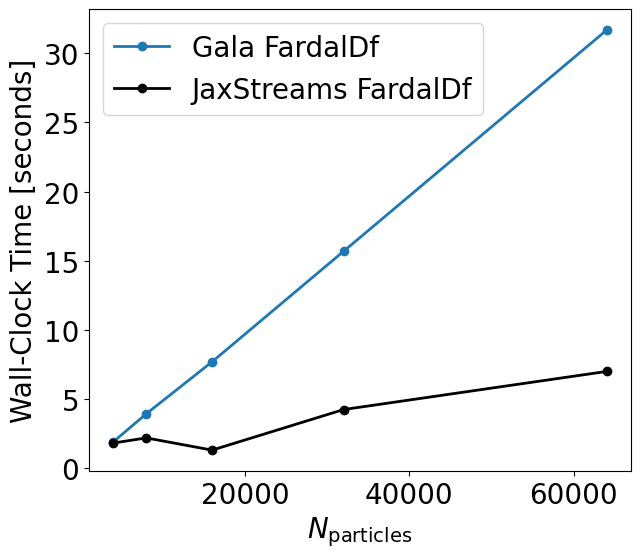

In [26]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(7, 6)
ax.plot(
    2 * np.array(n_release),
    t_gala,
    color="tab:blue",
    marker="o",
    lw=2,
    label="Gala FardalDf",
    rasterized=True,
)
ax.plot(
    2 * np.array(n_release),
    t_jax,
    color="k",
    marker="o",
    lw=2,
    label="JaxStreams FardalDf",
    rasterized=True,
)
ax.set_xlabel(r"$N_{\mathrm{particles}}$", fontsize=20)
ax.set_ylabel(r"Wall-Clock Time [seconds]", fontsize=20)
ax.tick_params(axis="both", labelsize=20)

ax.legend(fontsize=20)
######plt.savefig('Gala_versus_JaxStream_aftercompile.pdf',bbox_inches='tight')